<a href="https://colab.research.google.com/github/Ash100/Documents/blob/main/conjugates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Chemical Conjugation using SMILES**
This notebook allows you to provide two SMILES strings for molecules.  
It will automatically detect functional groups and predict possible conjugates.


In [ ]:
#@title Install RDKit and Pubchempy
!pip install rdkit-pypi pubchempy

In [2]:
#@title Import the required libraries
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, BRICS
from rdkit.Chem.Draw import IPythonConsole
import pubchempy as pcp
import pandas as pd

In [3]:
#@title Define functional group SMARTS patterns
functional_groups = {
    'Carboxylic acid': '[CX3](=O)[OX2H1]',
    'Amine': '[NX3;H2,H1;!$(NC=O)]',
    'Alcohol': '[OX2H]',
    'Aldehyde': '[CX3H1](=O)[#6]',
    'Ester': '[CX3](=O)[OX2H0][#6]',
    'Amide': '[CX3](=O)[NX3H2]',
    'Ketone': '[CX3](=O)[#6]',
    'Alkene': '[CX2]=[CX2]',
    'Alkyne': '[CX1]#[CX1]',
    'Nitro': '[NX3](=[OX1])=[OX1]'
}

def detect_functional_groups(smiles):
    """Detects functional groups in a molecule using SMARTS patterns."""
    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        return []
    matches = []
    for group_name, smarts in functional_groups.items():
        pattern = Chem.MolFromSmarts(smarts)
        if mol.HasSubstructMatch(pattern):
            matches.append(group_name)
    return matches


In [4]:
#@title Define correct reaction SMARTS with atom mappings or Reaction Rules
compatibility_rules = {
    ('Carboxylic acid', 'Amine'): {
        'reaction_type': 'amide_bond',
        'reaction_smarts': '[C:1](=[O:2])[O:3].[N:4]>>[C:1](=[O:2])[N:4]'
    },
    ('Alcohol', 'Carboxylic acid'): {
        'reaction_type': 'esterification',
        'reaction_smarts': '[C:1](=[O:2])[O:3].[O:4]>>[C:1](=[O:2])[O:4]'
    },
    ('Amine', 'Aldehyde'): {
        'reaction_type': 'Schiff_base',
        'reaction_smarts': '[N:1].[C:2]=[O:3]>>[N:1]=[C:2]'
    }
}


In [5]:
#@title Define Functions for Conjugates
def generate_conjugate(smiles1, smiles2):
    """Generates conjugates from two SMILES strings."""
    mol1 = Chem.MolFromSmiles(smiles1)
    mol2 = Chem.MolFromSmiles(smiles2)
    if not mol1 or not mol2:
        return "Error: Invalid SMILES input."

    fg1 = detect_functional_groups(smiles1)
    fg2 = detect_functional_groups(smiles2)

    conjugates = []
    for name1 in fg1:
        for name2 in fg2:
            for groups, rule in compatibility_rules.items():
                if (name1 in groups) and (name2 in groups):
                    rxn = AllChem.ReactionFromSmarts(rule["reaction_smarts"])
                    products = rxn.RunReactants((mol1, mol2))

                    if products:
                        for product in products:
                            product_smiles = Chem.MolToSmiles(product[0])
                            explanation = f"{name1} (from molecule 1) reacted with {name2} (from molecule 2) via {rule['reaction_type']}"
                            conjugates.append((product_smiles, explanation))
    return conjugates


In [11]:
# Import necessary libraries
from rdkit import Chem
from rdkit.Chem import AllChem
import ipywidgets as widgets
from IPython.display import display, FileLink
import pandas as pd

# Define widget inputs for SMILES
smiles1_input = widgets.Text(description="SMILES 1:", placeholder="Enter first SMILES")
smiles2_input = widgets.Text(description="SMILES 2:", placeholder="Enter second SMILES")
generate_button = widgets.Button(description="Generate Conjugates")

# Output display
output = widgets.Output()

# Function to handle button click
def on_generate_clicked(b):
    output.clear_output()
    with output:
        smiles1 = smiles1_input.value.strip()
        smiles2 = smiles2_input.value.strip()

        if not smiles1 or not smiles2:
            print("Error: Please enter valid SMILES strings.")
            return

        # Call the conjugate generation function
        conjugates = generate_conjugate(smiles1, smiles2)

        if isinstance(conjugates, str):  # Error handling
            print(conjugates)
        elif conjugates:
            # Convert results into a DataFrame
            df = pd.DataFrame(conjugates, columns=["Generated SMILES", "Reaction Explanation"])
            display(df)

            # Save DataFrame to CSV
            csv_filename = "conjugates_results.csv"
            df.to_csv(csv_filename, index=False)

            # Provide download link
            print("\nDownload the results:")
            display(FileLink(csv_filename))
        else:
            print("No conjugates could be generated.")

# Attach button click event
generate_button.on_click(on_generate_clicked)

# Display widgets and output area
display(smiles1_input, smiles2_input, generate_button, output)


Text(value='', description='SMILES 1:', placeholder='Enter first SMILES')

Text(value='', description='SMILES 2:', placeholder='Enter second SMILES')

Button(description='Generate Conjugates', style=ButtonStyle())

Output()

[18:25:47] Explicit valence for atom # 21 N, 5, is greater than permitted
[18:25:47] Explicit valence for atom # 21 N, 4, is greater than permitted
[18:25:47] Explicit valence for atom # 21 N, 5, is greater than permitted


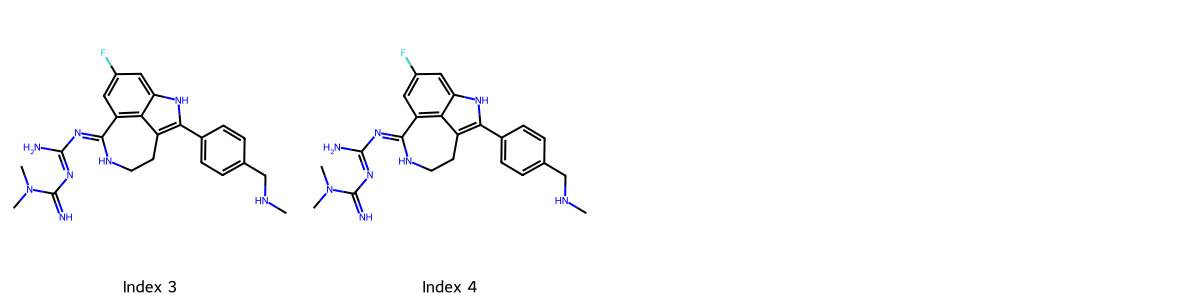

In [13]:
# Import necessary libraries
from rdkit import Chem
from rdkit.Chem import Draw
import pandas as pd
from IPython.display import display

# Load the generated SMILES from CSV
csv_filename = "conjugates_results.csv"
df = pd.read_csv(csv_filename)

valid_mols = []
legends = []

# Filter out invalid molecules
for i, smiles in enumerate(df["Generated SMILES"]):
    mol = Chem.MolFromSmiles(smiles)
    if mol:  # Only add valid molecules
        valid_mols.append(mol)
        legends.append(f"Index {i}")
    else:
        print(f"Warning: Skipping invalid SMILES at index {i} - {smiles}")

# Check if there are valid molecules to display
if valid_mols:
    img = Draw.MolsToGridImage(valid_mols, molsPerRow=4, subImgSize=(300, 300), legends=legends)
    display(img)
else:
    print("No valid SMILES available for visualization.")


In [14]:
# Import necessary libraries
from rdkit import Chem
from rdkit.Chem import Descriptors
import pandas as pd
from IPython.display import display

# Load the generated SMILES from CSV
csv_filename = "conjugates_results.csv"
df = pd.read_csv(csv_filename)

# Function to calculate Lipinski's parameters
def lipinski_properties(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        return None  # Skip invalid molecules
    mw = Descriptors.MolWt(mol)
    logp = Descriptors.MolLogP(mol)
    hbd = Descriptors.NumHDonors(mol)
    hba = Descriptors.NumHAcceptors(mol)
    lipinski_pass = (mw <= 500 and logp <= 5 and hbd <= 5 and hba <= 10)
    return [mw, logp, hbd, hba, lipinski_pass]

# Process valid molecules
lipinski_results = []
for smiles in df["Generated SMILES"]:
    props = lipinski_properties(smiles)
    if props:
        lipinski_results.append([smiles] + props)

# Convert to DataFrame
columns = ["SMILES", "MW", "LogP", "HBD", "HBA", "Lipinski Pass"]
lipinski_df = pd.DataFrame(lipinski_results, columns=columns)

# Display results
display(lipinski_df)

# Save results
lipinski_df.to_csv("lipinski_results.csv", index=False)
print("\nResults saved as lipinski_results.csv")


[18:29:33] Explicit valence for atom # 21 N, 5, is greater than permitted
[18:29:33] Explicit valence for atom # 21 N, 4, is greater than permitted
[18:29:33] Explicit valence for atom # 21 N, 5, is greater than permitted


,SMILES,MW,LogP,HBD,HBA,Lipinski Pass
0,CNCc1ccc(-c2[nH]c3cc(F)cc4c3c2CCNC4=NC(N)=NC(=...,434.523,2.39677,5,2,True
1,CNCc1ccc(-c2[nH]c3cc(F)cc4c3c2CCNC4=NC(N)=NC(=...,434.523,2.39677,5,2,True



Results saved as lipinski_results.csv


In [23]:
import requests
import pandas as pd
from rdkit import Chem

# Load the generated SMILES from CSV
csv_filename = "conjugates_results.csv"
df = pd.read_csv(csv_filename)

import requests

def get_admet_prediction(smiles):
    url = f"https://biosig.lab.uq.edu.au/pkcsm/prediction?smiles={smiles}"
    try:
        response = requests.get(url)  # Assuming GET method
        print(f"Raw API Response for SMILES {smiles}: {response.text}")  # Log raw response
        if response.status_code == 200:
            response_json = response.json()  # Try parsing as JSON
            if "prediction" in response_json:
                return response_json["prediction"]
            else:
                print(f"Error: No prediction data found for {smiles}")
        else:
            print(f"Error: Failed to get prediction for {smiles}, Status code: {response.status_code}")
    except Exception as e:
        print(f"Error: Exception while predicting for {smiles} - {e}")
    return None

# Process valid molecules
admet_results = []
for smiles in df["Generated SMILES"]:
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        prediction = get_admet_prediction(smiles)
        if prediction:
            admet_results.append([smiles] + list(prediction.values()))
        else:
            admet_results.append([smiles] + ['Error'] * 5)  # Placeholder for error case
    else:
        admet_results.append([smiles] + ['Invalid SMILES'] * 5)

# Convert to DataFrame
columns = ["SMILES", "Absorption", "Distribution", "Metabolism", "Excretion", "Toxicity"]
admet_df = pd.DataFrame(admet_results, columns=columns)

# Display results
display(admet_df)

# Save results
admet_df.to_csv("admet_results.csv", index=False)
print("\nResults saved as admet_results.csv")


[18:47:59] Explicit valence for atom # 21 N, 5, is greater than permitted
[18:47:59] Explicit valence for atom # 21 N, 4, is greater than permitted
[18:47:59] Explicit valence for atom # 21 N, 5, is greater than permitted


Raw API Response for SMILES CNCc1ccc(-c2[nH]c3cc(F)cc4c3c2CCNC4=NC(N)=NC(=N)N(C)C)cc1: <!DOCTYPE html>

<html lang="en">
<head>



<meta charset="utf-8">
<title>pkCSM</title>
<meta name="viewport" content="width=device-width, initial-scale=1.0">
<meta name="description" content="Web-version of pkCSM">
<meta name="author" content="Douglas Pires">
<link rel="canonical" href="https://biosig.lab.uq.edu.au/pkcsm/" />
<div class="alert alert-info">
	<strong> News!</strong> 🚀 Introducing the latest updates to our Pharmacokinetics and Toxicity predictors,  <a href="https://biosig.lab.uq.edu.au/deeppk"> Deep-PK, now available!</a>
</div>
<!-- Styles -->
<link href="/pkcsm/static/bootstrap/css/bootstrap.css" rel="stylesheet">
<style type="text/css">
	body {
	padding-top: 60px;
	padding-bottom: 40px;
	}
	td.dreta {
	text-align: right;
	}

.alert-info {
color: #FF00FF;
}
</style>

</style>

<link href="/pkcsm/static/bootstrap/css/bootstrap-responsive.css" rel="stylesheet">


<script src="/pkcsm/st

,SMILES,Absorption,Distribution,Metabolism,Excretion,Toxicity
0,CNCc1ccc(-c2[nH]c3cc(F)cc4c3c2CCNC4=N(C)(C)C(=...,Invalid SMILES,Invalid SMILES,Invalid SMILES,Invalid SMILES,Invalid SMILES
1,CNCc1ccc(-c2[nH]c3cc(F)cc4c3c2CCNC4=N=C(N=C(N)...,Invalid SMILES,Invalid SMILES,Invalid SMILES,Invalid SMILES,Invalid SMILES
2,CNCc1ccc(-c2[nH]c3cc(F)cc4c3c2CCNC4=N(C(=N)N(C...,Invalid SMILES,Invalid SMILES,Invalid SMILES,Invalid SMILES,Invalid SMILES
3,CNCc1ccc(-c2[nH]c3cc(F)cc4c3c2CCNC4=NC(N)=NC(=...,Error,Error,Error,Error,Error
4,CNCc1ccc(-c2[nH]c3cc(F)cc4c3c2CCNC4=NC(N)=NC(=...,Error,Error,Error,Error,Error



Results saved as admet_results.csv


In [18]:
import requests
import pandas as pd
from rdkit import Chem

# Load the generated SMILES from CSV
csv_filename = "conjugates_results.csv"
df = pd.read_csv(csv_filename)

# Function to predict toxicity
def predict_toxicity(smiles):
    url = "https://tox-api-server.com/predict"
    data = {"smiles": smiles}
    try:
        response = requests.post(url, data=data)
        # Check if the response status is OK
        if response.status_code == 200:
            response_json = response.json()
            if "toxicity" in response_json:
                return response_json["toxicity"]
            else:
                print(f"Error: No toxicity data found for {smiles}")
        else:
            print(f"Error: Failed to get toxicity prediction for {smiles}, Status code: {response.status_code}")
    except Exception as e:
        print(f"Error: Exception while predicting for {smiles} - {e}")
    return None

# Process valid molecules
toxicity_results = []
for smiles in df["Generated SMILES"]:
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        prediction = predict_toxicity(smiles)
        if prediction:
            toxicity_results.append([smiles] + list(prediction.values()))
        else:
            toxicity_results.append([smiles] + ['Error'] * 4)  # Placeholder for error case
    else:
        toxicity_results.append([smiles] + ['Invalid SMILES'] * 4)

# Convert to DataFrame
columns = ["SMILES", "Mutagenicity", "Carcinogenicity", "Hepatotoxicity", "Neurotoxicity"]
toxicity_df = pd.DataFrame(toxicity_results, columns=columns)

# Display results
display(toxicity_df)

# Save results
toxicity_df.to_csv("toxicity_results.csv", index=False)
print("\nResults saved as toxicity_results.csv")


Error: Exception while predicting for CNCc1ccc(-c2[nH]c3cc(F)cc4c3c2CCNC4=NC(N)=NC(=N)N(C)C)cc1 - HTTPSConnectionPool(host='tox-api-server.com', port=443): Max retries exceeded with url: /predict (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7c70f3f628d0>: Failed to resolve 'tox-api-server.com' ([Errno -2] Name or service not known)"))
Error: Exception while predicting for CNCc1ccc(-c2[nH]c3cc(F)cc4c3c2CCNC4=NC(N)=NC(=N)N(C)C)cc1 - HTTPSConnectionPool(host='tox-api-server.com', port=443): Max retries exceeded with url: /predict (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7c70f36e7490>: Failed to resolve 'tox-api-server.com' ([Errno -2] Name or service not known)"))


[18:34:25] Explicit valence for atom # 21 N, 5, is greater than permitted
[18:34:25] Explicit valence for atom # 21 N, 4, is greater than permitted
[18:34:25] Explicit valence for atom # 21 N, 5, is greater than permitted


,SMILES,Mutagenicity,Carcinogenicity,Hepatotoxicity,Neurotoxicity
0,CNCc1ccc(-c2[nH]c3cc(F)cc4c3c2CCNC4=N(C)(C)C(=...,Invalid SMILES,Invalid SMILES,Invalid SMILES,Invalid SMILES
1,CNCc1ccc(-c2[nH]c3cc(F)cc4c3c2CCNC4=N=C(N=C(N)...,Invalid SMILES,Invalid SMILES,Invalid SMILES,Invalid SMILES
2,CNCc1ccc(-c2[nH]c3cc(F)cc4c3c2CCNC4=N(C(=N)N(C...,Invalid SMILES,Invalid SMILES,Invalid SMILES,Invalid SMILES
3,CNCc1ccc(-c2[nH]c3cc(F)cc4c3c2CCNC4=NC(N)=NC(=...,Error,Error,Error,Error
4,CNCc1ccc(-c2[nH]c3cc(F)cc4c3c2CCNC4=NC(N)=NC(=...,Error,Error,Error,Error



Results saved as toxicity_results.csv


In [20]:
# Function to get ADMET predictions from pkCSM with full logging
def get_admet_prediction(smiles):
    url = "https://biosig.lab.uq.edu.au/pkcsm/prediction"
    data = {"smiles": smiles}
    try:
        response = requests.post(url, data=data)
        if response.status_code == 200:
            response_json = response.json()
            # Log the entire response for debugging
            print(f"API Response for SMILES {smiles}: {response_json}")
            if "prediction" in response_json:
                return response_json["prediction"]
            else:
                print(f"Error: No prediction data found for {smiles}")
        else:
            print(f"Error: Failed to get prediction for {smiles}, Status code: {response.status_code}")
    except Exception as e:
        print(f"Error: Exception while predicting for {smiles} - {e}")
    return None
